# NIVEL 1

Descàrrega els arxius CSV, estudia'ls i dissenya una base de dades amb un esquema d'estrella que contingui, almenys 4 taules
Aqui una imagen del diseño de mi esquema:

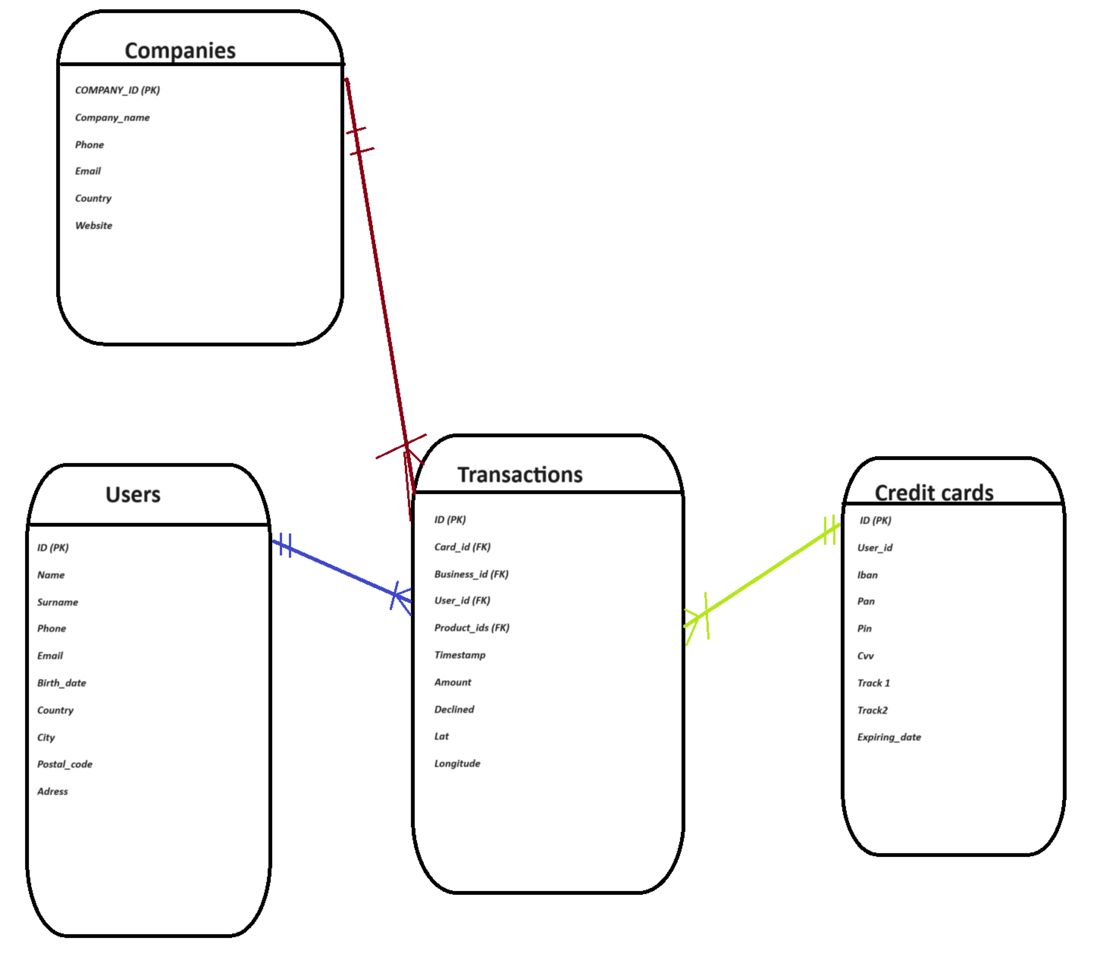

una pequeña aclaración: en este esquema no he incluido la tabla products porque para poder hacer el ejercicio 1 del nivel 3 hay que transformar los datos de la misma (cuando haga ese ejercicio incluiré imagenes del proceso y de la tabla ya relacionada con el esquema)
Aquí el esquema ya creado
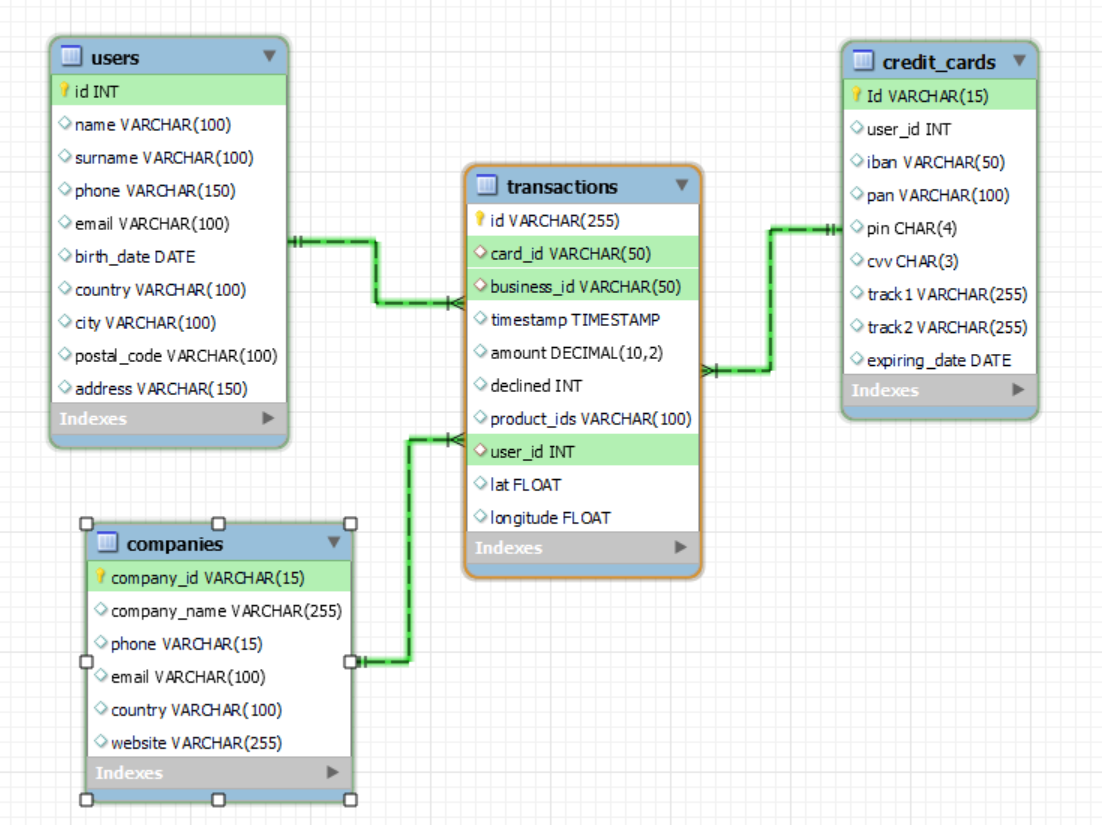

### Exercici 1
Realitza una subconsulta que mostri tots els usuaris amb més de 30 transaccions utilitzant almenys 2 taules.
## OPCIÓN SIN SUBCONSULTA
Vi que lo podia hacer tambien sin subconsulta (y dado que para mi eso es mas conveniente, decidí mostrar tambien esta opción)


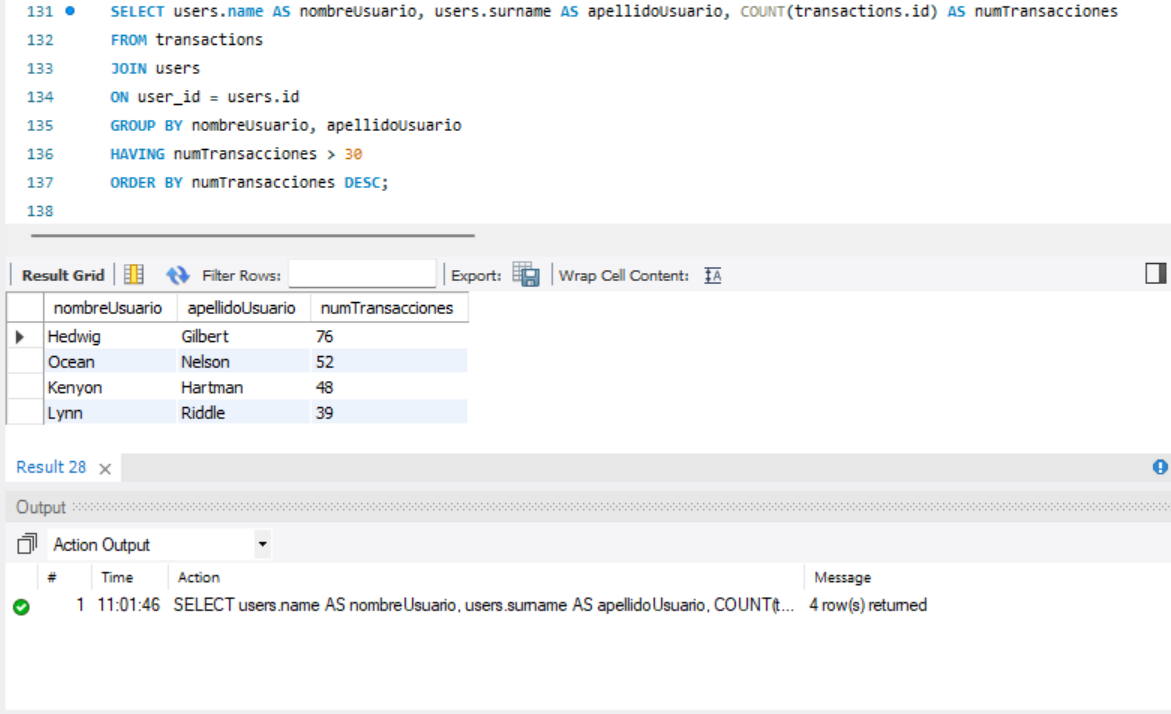

## OPCIÓN CON SUBCONSULTA

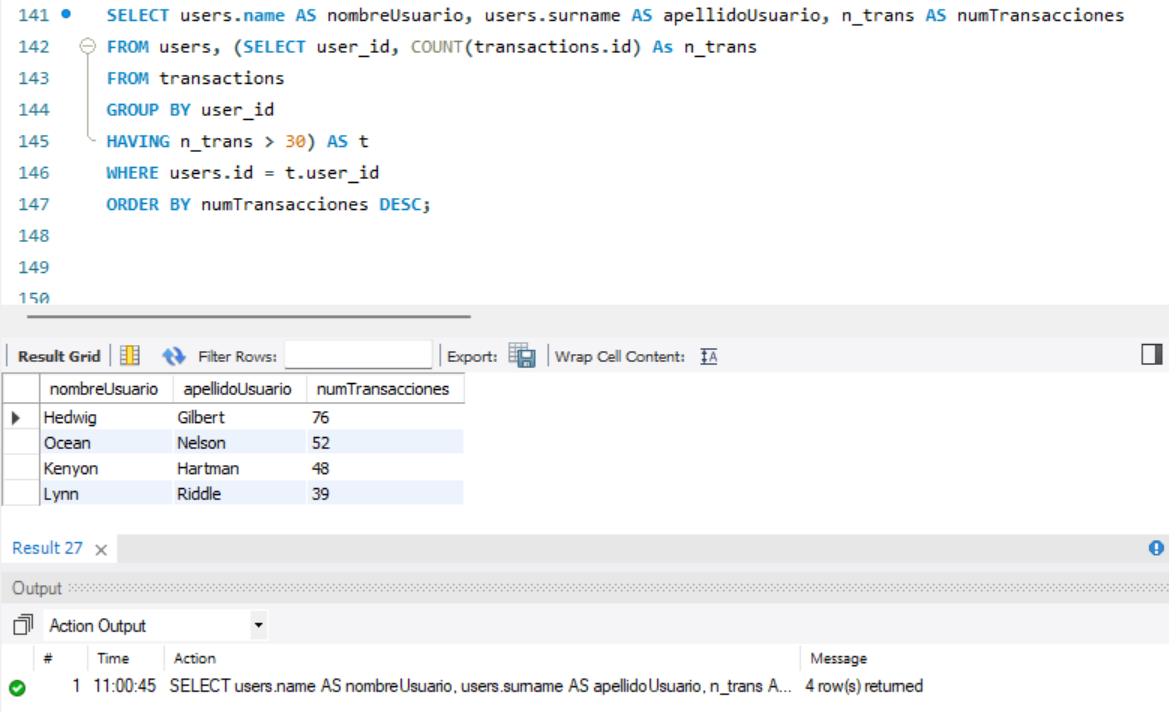

### Exercici 2
Mostra la mitjana de la suma de transaccions per IBAN de les targetes de crèdit en la companyia Donec Ltd. utilitzant almenys 2 taules.

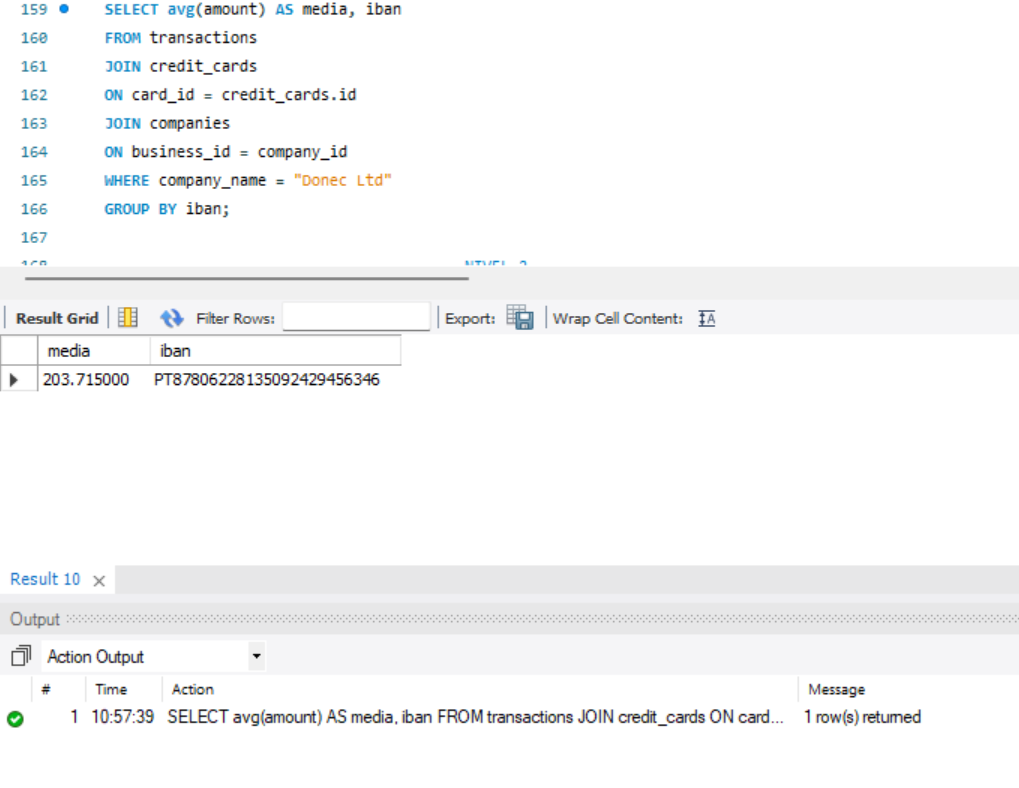

# NIVEL 2 


Crea una nova taula que reflecteixi l'estat de les targetes de crèdit basat en si les últimes tres transaccions van ser declinades i genera la següent consulta:
Creando la tabla:

Utilizo la función row_number para recorrer la tabla transactions y generar una columna numerada de hasta 3 registros ordenada por el timestamp de forma descendente
Utilizo la función if para devolver la expresión "inactiva" cuando la suma de los 3 valores en la columna declined (para cada card_id) es igual a 3, o activa cuando esta
condición no se cumple

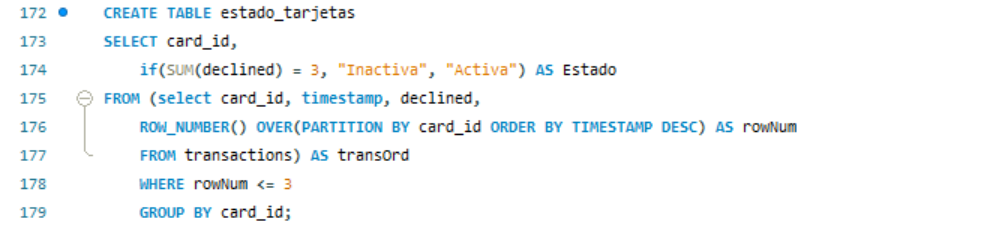


### Exercici 1
Quantes targetes estan actives?

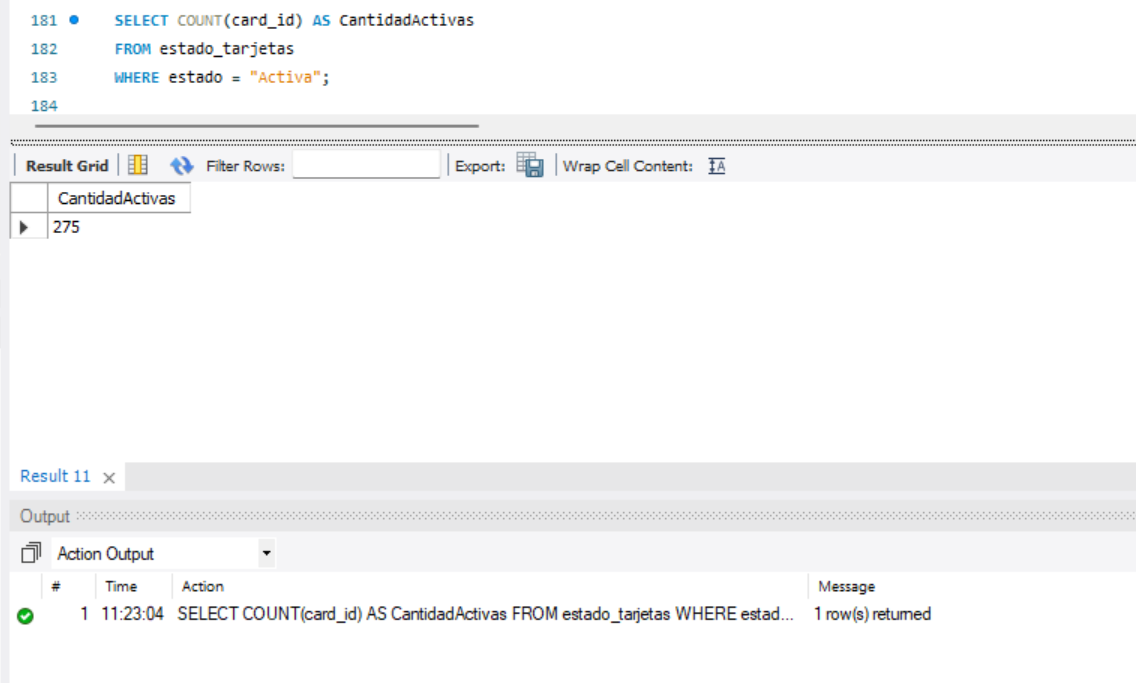

# NIVEL 3

Primero creamos la tabla products e ingresamos los datos

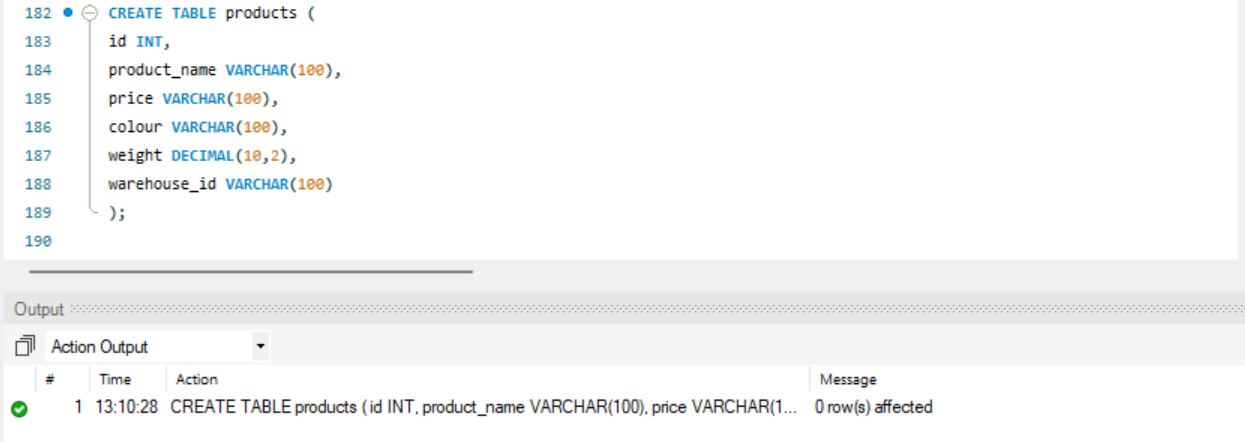

luego creamos la tabla intermedia 

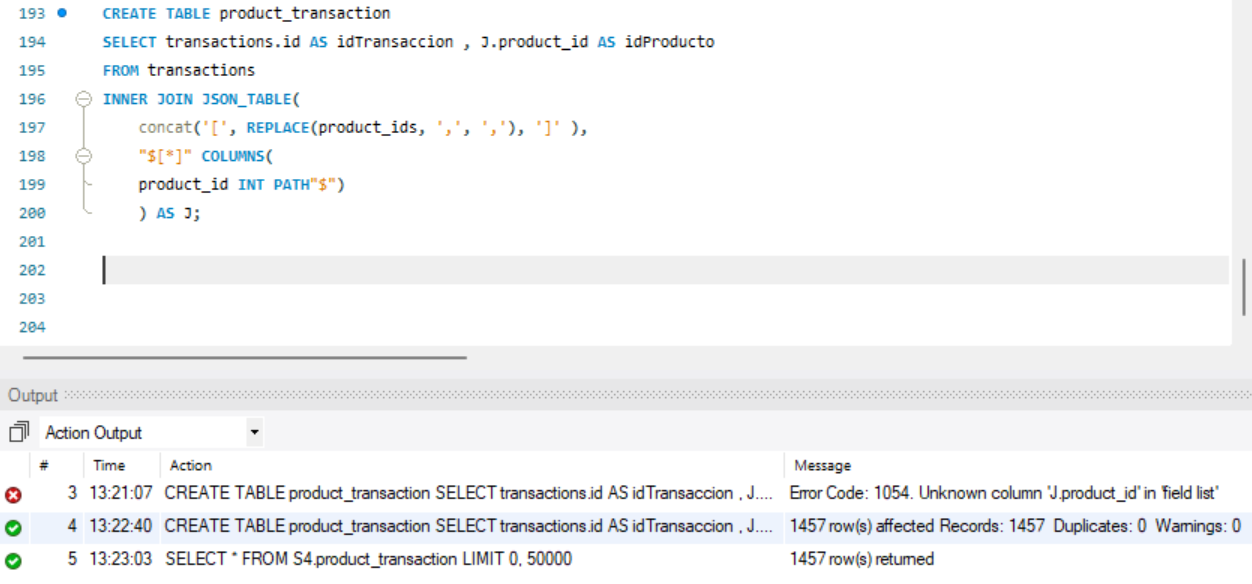

Aquí utilizamos la función JSON_TABLE para insertar los datos de la columna product_ids que estaban separados por comas, en diferentes filas, para asi luego poder recorrerlos de 
forma correcta.

Luego creamos la consulta para mostrar cuantas veces se ha vendido cada producto 

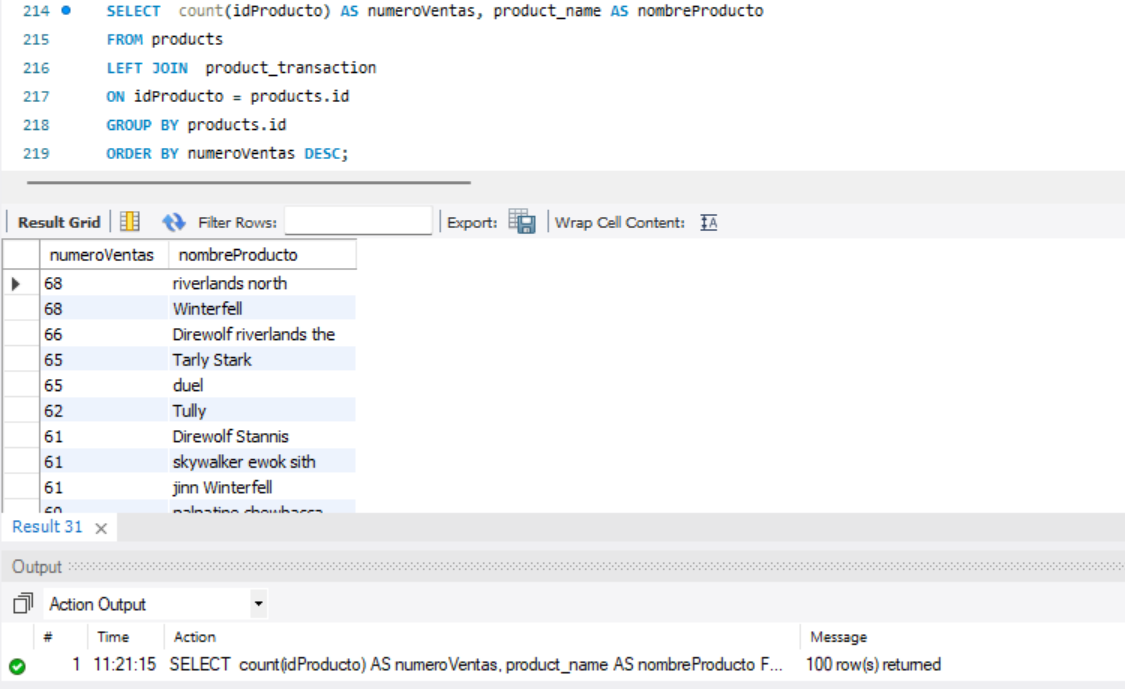

Es muy importante agrupar por product.id, ya que hay varios productos con mismo nombre pero diferente product.id



creando relaciones con estado_tarjeta

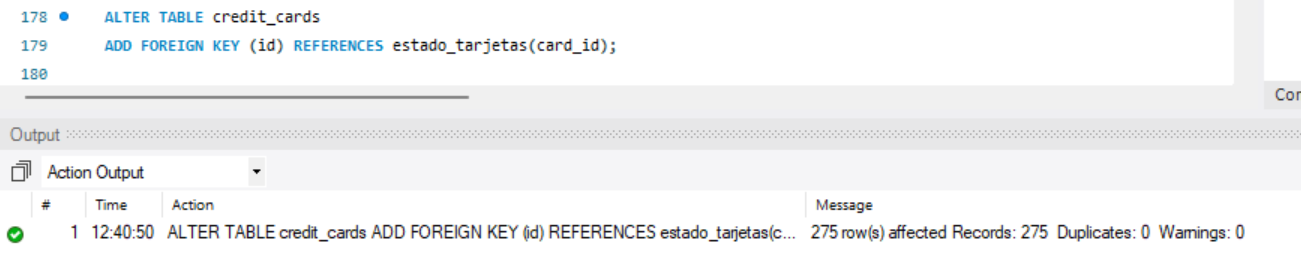


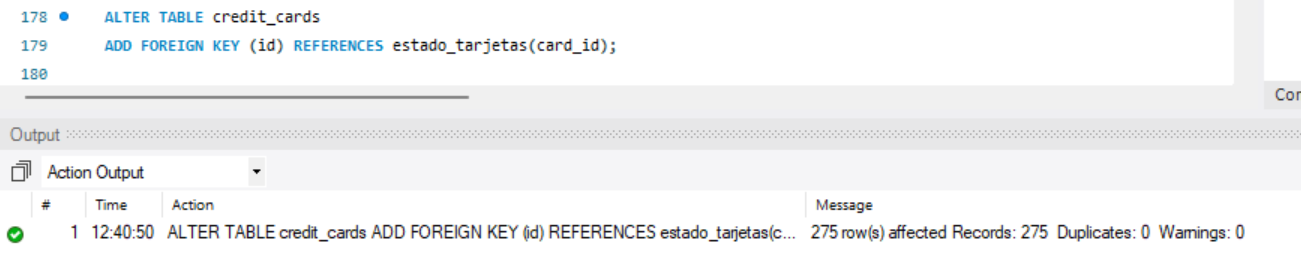

Luego de todas estas transformaciones asi nos quedaría relacionado el esquema

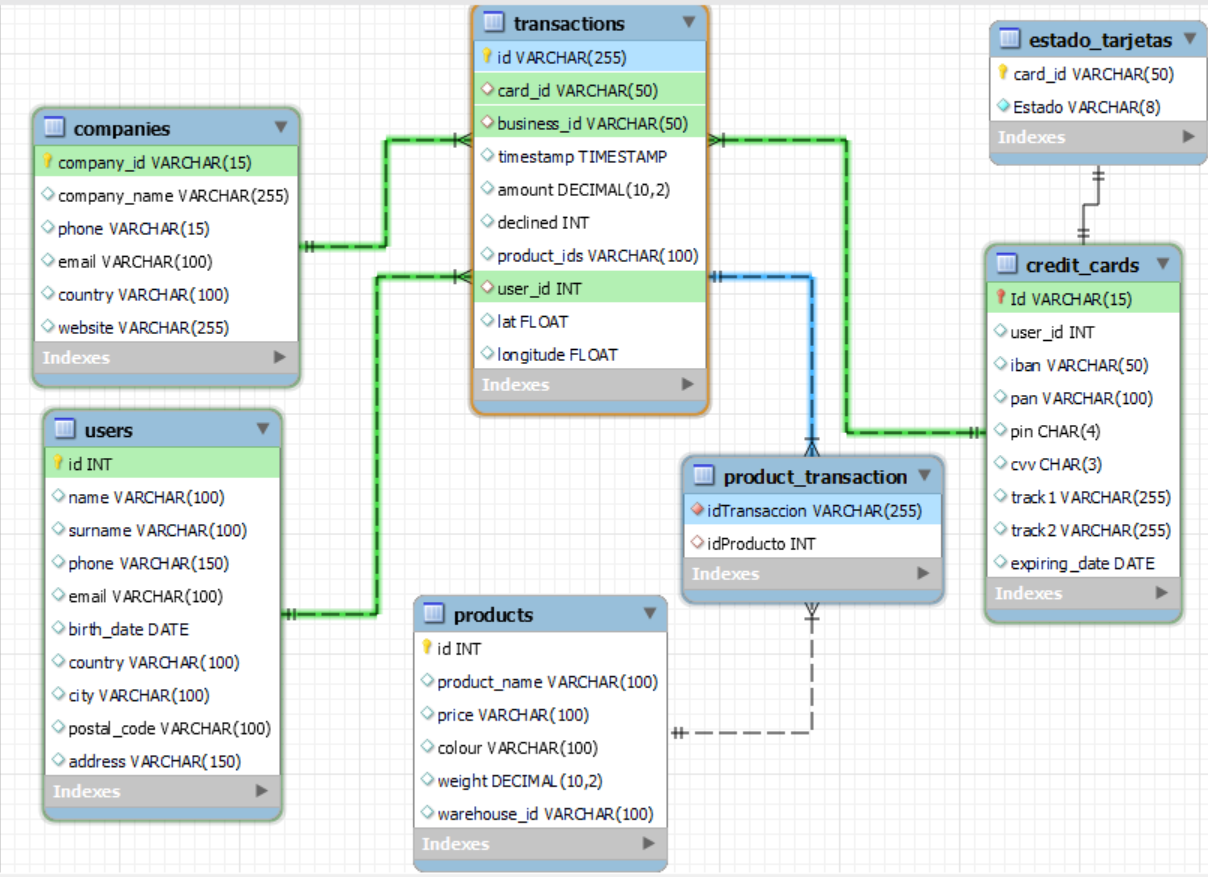



## Debajo dejo todo el codigo utilizado

```
CREATE DATABASE S4;
USE S4;

CREATE TABLE companies (
company_id VARCHAR(15),
company_name VARCHAR(255),
phone VARCHAR(15),
email VARCHAR(100),
country VARCHAR(100),
website VARCHAR(255)
);

CREATE TABLE credit_cards (
id VARCHAR(15),
user_id INT,
iban VARCHAR(50),
pan VARCHAR(100),
pin CHAR(4),
cvv CHAR(3),
track1 VARCHAR(255),
track2 VARCHAR(255),
expiring_date VARCHAR(100));

CREATE TABLE credit_cards2 (
id VARCHAR(15),
user_id INT,
iban VARCHAR(50),
pan VARCHAR(100),
pin CHAR(4),
cvv CHAR(3),
track1 VARCHAR(255),
track2 VARCHAR(255),
expiring_date DATE);


CREATE TABLE users(id INT,
name VARCHAR(100),
surname VARCHAR(100),
phone VARCHAR(150),
email VARCHAR(100),
birth_date VARCHAR(100),
country VARCHAR(100),
city VARCHAR(100),
postal_code VARCHAR(100),
address VARCHAR(150)
);


CREATE TABLE users2(id INT,
name VARCHAR(100),
surname VARCHAR(100),
phone VARCHAR(150),
email VARCHAR(100),
birth_date DATE,
country VARCHAR(100),
city VARCHAR(100),
postal_code VARCHAR(100),
address VARCHAR(150)
);


INSERT INTO credit_cards2(id, user_id, iban, pan, pin, cvv, track1, track2, expiring_date)
SELECT id, user_id, iban, pan, pin, cvv, track1, track2, str_to_date(expiring_date, '%m/%d/%Y') AS fecha_convertida
FROM credit_cards;



DROP TABLE credit_cards;

ALTER TABLE credit_cards2
RENAME TO credit_cards;


INSERT INTO users2 (id, name, surname, phone, email, birth_date, country, city, postal_code, address)
SELECT id, name, surname, phone, email, str_to_date(birth_date, '%M %d, %Y'), country, city, postal_code, address
FROM users;

DROP TABLE users;

ALTER TABLE users2
RENAME TO users;


CREATE TABLE transactions(
id VARCHAR(255),
card_id VARCHAR(50),
business_id VARCHAR(50),
timestamp TIMESTAMP,
amount DECIMAL(10,2),
declined INT,
product_ids VARCHAR(100),
user_id INT,
lat FLOAT,
longitude FLOAT
);





ALTER TABLE users
MODIFY COLUMN id INT PRIMARY KEY;


ALTER TABLE companies
MODIFY COLUMN company_id VARCHAR(15) PRIMARY KEY;

ALTER TABLE credit_cards
MODIFY COLUMN id VARCHAR(15) PRIMARY KEY;

ALTER TABLE transactions
MODIFY COLUMN id VARCHAR(255) PRIMARY KEY;





ALTER TABLE transactions
ADD FOREIGN KEY (user_id) REFERENCES users(id);

ALTER TABLE transactions
ADD FOREIGN KEY (business_id) REFERENCES companies(company_id);


ALTER TABLE transactions
ADD FOREIGN KEY (card_id) REFERENCES credit_cards(id);


-- Ejercicio 1
-- opcion sin subconsulta
SELECT users.name AS nombreUsuario, users.surname AS apellidoUsuario, COUNT(transactions.id) AS numTransacciones
FROM transactions
JOIN users
ON user_id = users.id
GROUP BY nombreUsuario, apellidoUsuario
HAVING numTransacciones > 30
ORDER BY numTransacciones DESC;

-- opcion con subconsulta

SELECT users.name AS nombreUsuario, users.surname AS apellidoUsuario, n_trans AS numTransacciones
FROM users, (SELECT user_id, COUNT(transactions.id) As n_trans
FROM transactions
GROUP BY user_id
HAVING n_trans > 30) AS t
WHERE users.id = t.user_id
ORDER BY numTransacciones DESC;



-- Ejercicio 2

SELECT avg(amount) AS media, iban
FROM transactions
JOIN credit_cards
ON card_id = credit_cards.id
JOIN companies
ON business_id = company_id
WHERE company_name = "Donec Ltd"
GROUP BY iban;

-- ------------------------------------ NIVEL 2 ----------------------------------------------------------
-- ejercicio 1


CREATE TABLE estado_tarjetas;
SELECT card_id,
	if(SUM(declined) = 3, "Inactiva", "Activa") AS Estado
FROM (select card_id, timestamp, declined,
	ROW_NUMBER() OVER(PARTITION BY card_id ORDER BY TIMESTAMP DESC) AS rowNum
    FROM transactions) AS transOrd
    WHERE rowNum <= 3
    GROUP BY card_id;

ALTER TABLE estado_tarjetas
MODIFY COLUMN card_id VARCHAR (50) PRIMARY KEY;

ALTER TABLE credit_cards
ADD FOREIGN KEY (id) REFERENCES estado_tarjetas(card_id);

SELECT COUNT(card_id) AS CantidadActivas
FROM estado_tarjetas
WHERE estado = "Activa";

select *
FROM estado_tarjetas;

-- ---------------------------------------- NIVEL 3 ------------------------------------------------------------------------

-- Ejercicio 1
-- creamos la tabla products
CREATE TABLE products (
id INT,
product_name VARCHAR(100),
price VARCHAR(100),
colour VARCHAR(100),
weight DECIMAL(10,2),
warehouse_id VARCHAR(100) 
);

-- creamos tabla intermedia con los product_ids separados

CREATE TABLE product_transaction
SELECT transactions.id AS idTransaccion , J.product_id AS idProducto
FROM transactions 
INNER JOIN JSON_TABLE(
	concat('[', REPLACE(product_ids, ',', ','), ']' ), 
    "$[*]" COLUMNS(
    product_id INT PATH"$") 
    ) AS J;


ALTER TABLE products
MODIFY COLUMN id INT PRIMARY KEY;

ALTER TABLE product_transaction
ADD FOREIGN KEY (idTransaccion) REFERENCES transactions(id);

-- ejecutamos la consulta para mostrar cuantas veces se ha vendido cada roducto
SELECT  count(idProducto) AS numeroVentas, product_name AS nombreProducto
FROM products
LEFT JOIN  product_transaction
ON idProducto = products.id
GROUP BY products.id
ORDER BY numeroVentas DESC;


```